In [2]:
# Packages
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from linearmodels.panel import PanelOLS, compare
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
# Set correct path to data directory

# Load data
data = pd.read_csv(r'C:\Users\yahsk\Desktop\Q3\data analytics\23S-MGMTMFE-431-LEC-2-Special-Topics-in-Financial-Engineering-2023-Jun-22_08-41-26-062\23S-MGMTMFE-431-LEC-2-Special-Topics-in-Financial-Engineering-2023-Jun-22_08-41-26-062\viewer\files\StockRetAcct_DT.csv').iloc[:, 1:].dropna()


In [3]:
# Add lnBE and lnBE2
#data["lnMB"] = -data["lnBM"]
data["lnBE"] = data["lnBM"] + data["lnME"]
data["lnBE2"] = (data["lnBM"] + data["lnME"]) ** 2
# Square all other characteristics and interact them with lnBE
col = ["lnIssue", "lnProf", "lnInv", "lnLever", "lnMom", "lnROE", "rv"]
for c in col:
    data[f"{c}2"] = data[c] ** 2
    data[f"{c}inter"] = data[c] * data["lnBE"]
    
# De-mean by industry-year
for c in col:
    data[[c, f"{c}2", f"{c}inter"]] = data.groupby(['year', 'ff_ind'])[[c,
f"{c}2", f"{c}inter"]].transform(lambda x: x - x.mean())
data[['lnBM', 'lnBE', 'lnBE2']] = data.groupby(['year', 'ff_ind'])[['lnBM',
'lnBE', 'lnBE2']].transform(lambda x: x - x.mean())
# Data Overview
data.head()

,FirmID,year,lnAnnRet,lnRf,MEwt,lnIssue,lnMom,lnME,lnProf,lnEP,...,lnInv2,lnInvinter,lnLever2,lnLeverinter,lnMom2,lnMominter,lnROE2,lnROEinter,rv2,rvinter
0,6,1980,0.363631,0.078944,0.000281,-0.031518,-0.043815,12.581472,-0.065414,0.146411,...,-0.045275,-0.877767,-0.135418,0.220836,-0.077018,-0.442526,-0.023986,-0.807718,-0.010919,-0.385629
1,6,1981,-0.290409,0.130199,0.000321,-0.016698,0.082219,12.907996,-0.020724,0.102555,...,-0.026850,-0.476887,-0.068848,0.693242,-0.019577,1.503954,-0.019490,-0.677636,-0.012492,-0.657958
2,6,1982,0.186630,0.130703,0.000266,-0.119505,0.063051,12.557775,-0.040975,0.119548,...,-0.017624,0.152454,-0.049602,1.087056,-0.131375,0.704359,-0.022464,-0.704323,-0.010319,-0.506714
3,6,1983,0.489819,0.089830,0.000170,-0.134396,-0.432452,12.561954,0.001125,0.115924,...,-0.012699,-0.701114,-0.070404,0.772906,-0.305134,-5.443163,-0.022040,-0.189306,-0.015790,-0.703336
4,10,1991,-0.508005,0.061216,0.000033,-0.121984,0.846865,11.565831,0.118796,0.023147,...,-0.021621,0.541536,-0.291178,-2.780962,1.383746,7.012217,-0.037233,0.290212,0.057670,0.689237


(0.0, 1.0)

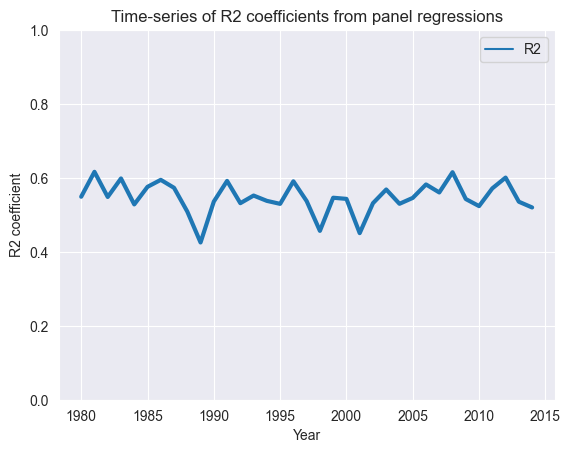

In [4]:
# Initiate iterator and output variables for cross-sectional regression
years = sorted(data['year'].unique())
R2 = np.zeros(len(years))
lnBM_hat_OLS = np.zeros(len(data))
coef_table = pd.DataFrame()
# Each year, regress lnME on all characteristics and industries
for i, t in enumerate(years):
    indx = data['year'] == t
    data_tmp = data.loc[indx].reset_index(drop=True)
    
    regtmp = smf.ols(
        "lnBM ~ lnBE + lnBE2 + lnIssue + lnIssue2 + lnIssueinter + lnProf + lnProf2 + lnProfinter + "
        "lnInv + lnInv2 + lnInvinter + lnLever + lnLever2 + lnLeverinter + lnMom + lnMom2 + lnMominter + "
        "lnROE + lnROE2 + lnROEinter + rv + rv2 + rvinter",
        data=data_tmp
    ).fit()

    R2[i] = regtmp.rsquared  # extracts the R2 coefficient
    
    tmp = regtmp.params.to_dict()
    tmp['year'] = t
    coef_table = coef_table.append(tmp, ignore_index=True)
    
    lnBM_hat_OLS[indx] = regtmp.predict(data_tmp)  # extraces the fitted values

data["lnBM_hat_OLS"] = lnBM_hat_OLS

# Plot the R2 coefficients across time - these are R2 coefficients WITHIN industries
summary = pd.DataFrame()
summary['year'] = years
summary['R2'] = R2
summary = summary.set_index('year')

sns.set_style('darkgrid')
plt.figure()
ax = sns.lineplot(data=summary, dashes=False, linewidth=3)
ax.set(xlabel='Year', ylabel='R2 coefficient', title="Time-series of R2 coefficients from panel regressions")
ax.set_ylim(bottom=0, top=1)

[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Coefficient'),
 Text(0.5, 1.0, 'Time-series of coefficients from panel regressions')]

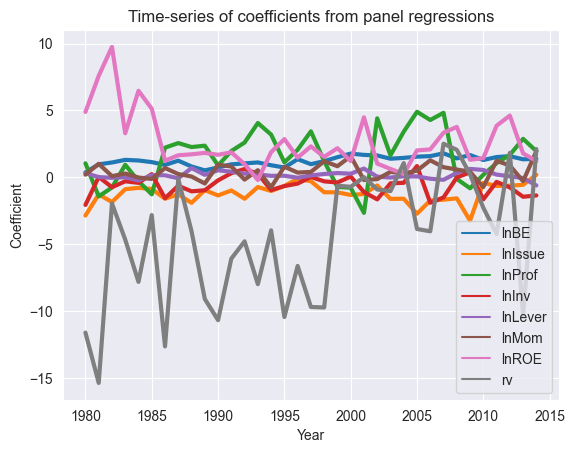

In [5]:
coef_table = coef_table.set_index('year')
sns.set_style('darkgrid')
plt.figure()
ax = sns.lineplot(data=coef_table[['lnBE'] + col], dashes=False, linewidth=3)
ax.set(xlabel='Year',
    ylabel='Coefficient',
    title="Time-series of coefficients from panel regressions")
#ax.set_ylim(bottom=0, top=1)

In [6]:
# Define Fama-MacBeth regression
def ols_coef(x, formula):
    return smf.ols(formula, data=x).fit().params
# Define excess return
data['ExRet'] = np.exp(data.lnAnnRet) - np.exp(data.lnRf)
# Define the mispricing measure z_OLS
data['z_OLS'] = data.lnBM - data.lnBM_hat_OLS
# Run Fama-MacBeth regression
res = (data.groupby('year').apply(ols_coef, 'ExRet ~ z_OLS'))
# Print the result
print('Mean Return: ', str(res['z_OLS'].mean())+'\n',
'Std Dev: ', str(res['z_OLS'].std())+'\n',
'Sharpe Ratio ', str(res['z_OLS'].mean() /
res['z_OLS'].std())+'\n',
't-stat: ', str(len(years)**.5*(res['z_OLS'].mean()) /
res['z_OLS'].std()), sep="\n")

Mean Return: 
0.026386647363474392

Std Dev: 
0.07801098640695345

Sharpe Ratio 
0.338242708864433

t-stat: 
2.0010708516937212


In [7]:

res = (data.groupby('year').apply(
    ols_coef, 'ExRet ~ z_OLS + lnBM_hat_OLS + lnProf + lnInv + lnMom'))
# Print the result
print('Mean Return: ', str(res['z_OLS'].mean())+'\n',
'Std Dev: ', str(res['z_OLS'].std())+'\n',
'Sharpe Ratio ', str(res['z_OLS'].mean() /
res['z_OLS'].std())+'\n',
't-stat: ', str(len(years)**.5*(res['z_OLS'].mean()) /
res['z_OLS'].std()), sep="\n")

Mean Return: 
0.02638664736347403

Std Dev: 
0.07801098640695336

Sharpe Ratio 
0.3382427088644287

t-stat: 
2.001070851693696


In [8]:
# Print the result
print('Mean Return: ', str(res['lnBM_hat_OLS'].mean())+'\n',
'Std Dev: ', str(res['lnBM_hat_OLS'].std())+'\n',
'Sharpe Ratio ', str(res['lnBM_hat_OLS'].mean() /
res['lnBM_hat_OLS'].std())+'\n',
't-stat: ', str(len(years)**.5*(res['lnBM_hat_OLS'].mean()) /
res['lnBM_hat_OLS'].std()), sep="\n")

Mean Return: 
0.024593607952778263

Std Dev: 
0.09802425340392151

Sharpe Ratio 
0.25089309123770775

t-stat: 
1.4843035447907702


(0.0, 0.04)

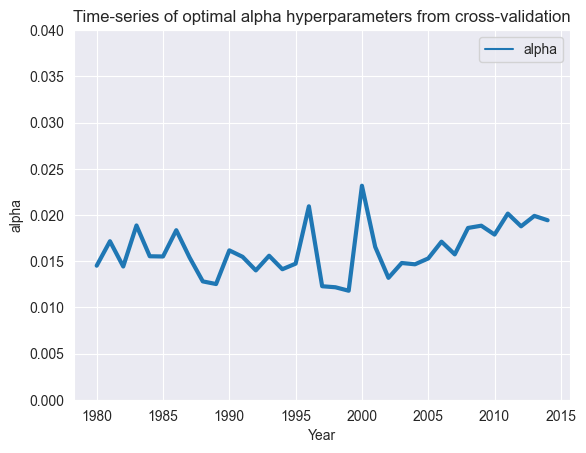

In [11]:
# Initialize array to store optimal alpha for each year
optimal_alphas = np.zeros(len(years))
data["lnBM_hat_EN"] = np.nan
# Loop over years
for i in range(len(years)):
    year = years[i]
    data_year = data[data["year"] == year]
    # ElasticNet with cross-validation
    y_year = data_year["lnBM"]
    X_year = data_year.drop(["lnME", "FirmID", "lnAnnRet", "lnRf", "MEwt",
    "lnEP", "year", "ff_ind", "lnBM_hat_OLS",
    "z_OLS", "ExRet", "lnBM_hat_EN", "lnBM"], axis=1)
    model_year = ElasticNetCV(l1_ratio=0.5, cv=10)
    model_year.fit(X_year, y_year)
    alpha_optim = model_year.alpha_
    optimal_alphas[i] = alpha_optim
    # ElasticNet without cross-validation
    model = ElasticNet(alpha=alpha_optim, l1_ratio=0.5, max_iter=10000)
    model.fit(X_year, y_year)
    data.loc[data.year == year, "lnBM_hat_EN"] = model.predict(X_year)
# Plot the optimal alpha coefficients from cross-validation
summary = pd.DataFrame()
summary['year'] = years
summary['alpha'] = optimal_alphas
summary = summary.set_index('year')
sns.set_style('darkgrid')
plt.figure()
ax = sns.lineplot(data=summary, dashes=False, linewidth=3)
ax.set(xlabel='Year',
    ylabel='alpha',
    title="Time-series of optimal alpha hyperparameters from cross-validation")
ax.set_ylim(bottom=0, top=0.04)

(0.0, 1.0)

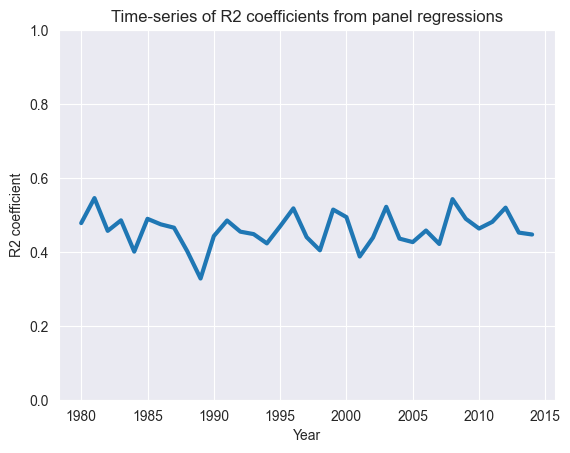

In [12]:
def ols_r2(x, formula):
    return smf.ols(formula, data=x).fit().rsquared


# Plot the R2 coefficients across time
resr2 = (data.groupby('year').apply(ols_r2, 'lnBM ~ lnBM_hat_EN'))
sns.set_style('darkgrid')
plt.figure()
ax = sns.lineplot(data=resr2, dashes=False, linewidth=3)
ax.set(xlabel='Year',
        ylabel='R2 coefficient',
        title="Time-series of R2 coefficients from panel regressions")
ax.set_ylim(bottom=0, top=1)

In [14]:
# Define the mispricing measure z_EN
data['z_EN'] = data.lnBM - data.lnBM_hat_EN
# Run Fama MacBeth regression
res = (data.groupby('year').apply(ols_coef, 'ExRet ~ z_EN'))
# Print the result
print('Mean Return: ', str(res['z_EN'].mean())+'\n',
'Std Dev: ', str(res['z_EN'].std())+'\n',
'Sharpe Ratio ', str(res['z_EN'].mean() /
res['z_EN'].std())+'\n',
't-stat: ', str(len(years)**.5*(res['z_EN'].mean())/
res['z_EN'].std()), sep="\n")

Mean Return: 
0.03318679060072934

Std Dev: 
0.0819857416867269

Sharpe Ratio 
0.40478734372542885

t-stat: 
2.394754220668605


In [16]:

# Run Fama-MacBeth regression controlling for lnBM, lnProf, lnInv, and lnMom
res = (data.groupby('year').apply(
ols_coef, 'ExRet ~ z_EN + lnBM_hat_EN + lnProf + lnInv + lnMom'))
# Print the result
print('Mean Return: ', str(res['z_EN'].mean())+'\n',
'Std Dev: ', str(res['z_EN'].std())+'\n',
'Sharpe Ratio ', str(res['z_EN'].mean() /
res['z_EN'].std())+'\n',
't-stat: ', str(len(years)**.5*(res['z_EN'].mean()) /
res['z_EN'].std()), sep="\n")

Mean Return: 
0.031654535860842714

Std Dev: 
0.07938444035774025

Sharpe Ratio 
0.3987498774091476

t-stat: 
2.3590360882537085


In [17]:
# Print the result
print('Mean Return: ', str(res['lnBM_hat_EN'].mean())+'\n',
'Std Dev: ', str(res['lnBM_hat_EN'].std())+'\n',
'Sharpe Ratio ', str(res['lnBM_hat_EN'].mean() /
res['lnBM_hat_EN'].std())+'\n',
't-stat: ', str(len(years)**.5*(res['lnBM_hat_EN'].mean()) /
res['lnBM_hat_EN'].std()), sep="\n")

Mean Return: 
0.011991094387608314

Std Dev: 
0.13166909759263973

Sharpe Ratio 
0.09106992154458735

t-stat: 
0.5387769216984014


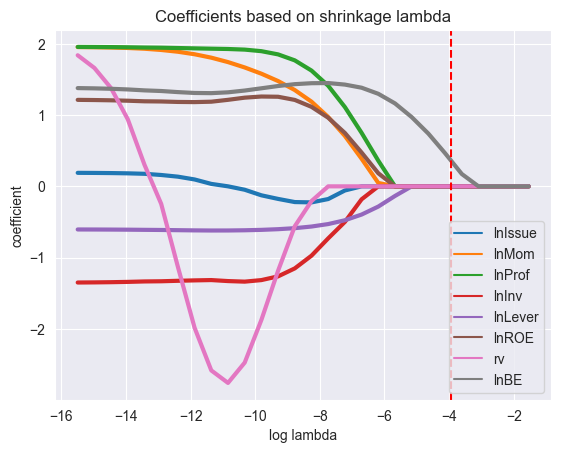

In [22]:
# Initialize array to store optimal alpha for each year
alphas = 10**np.linspace(10, -1, 50)*0.02
lambdas = 1/alphas[7:35]
data_year = data.loc[data['year'] == 2014]
y_year = data_year["lnBM"]
X_year = data_year.drop(["lnME", "FirmID", "lnAnnRet", "lnRf", "MEwt", "lnEP",
"year", "ff_ind", "lnBM_hat_OLS",
"z_OLS", "ExRet", "lnBM_hat_EN", "lnBM", "z_EN"],
axis=1)
coef_names = list(X_year.columns)[0:8]
summary = pd.DataFrame(columns=coef_names)
# Loop over lambdas
for i in range(len(lambdas)):
    lambdai = lambdas[i]
    # ElasticNet without cross-validation
    model = ElasticNet(alpha=lambdai, l1_ratio=0.5, max_iter=10000)
    model.fit(X_year, y_year)
    summary.loc[i] = model.coef_[0:8]
summary['lnLambda'] = np.log(lambdas)
summary = summary.set_index('lnLambda')
sns.set_style('darkgrid')
plt.figure()
ax = sns.lineplot(data=summary, dashes=False, linewidth=3)
ax.set(xlabel='log lambda',
ylabel='coefficient',
title="Coefficients based on shrinkage lambda")
plt.axvline(x=np.log(optimal_alphas[len(years)-1]), color='r', linestyle='--')

In [23]:
# For comparison, the optimal parameters:
model = ElasticNet(alpha=optimal_alphas[len(optimal_alphas)-1], l1_ratio=0.5,
max_iter=10000)
model.fit(X_year, y_year)
summary = pd.DataFrame()
summary['variable'] = list(X_year.columns)
summary['coefficient'] = model.coef_
print(summary.loc[summary['coefficient'] != 0.0])

        variable  coefficient
7           lnBE     0.361705
8          lnBE2    -0.006750
10  lnIssueinter     0.001211
11       lnProf2    -0.914941
12   lnProfinter    -0.038586
14    lnInvinter    -0.035197
15      lnLever2    -0.029956
16  lnLeverinter     0.002173
18    lnMominter    -0.025145
19        lnROE2    -0.289742
20    lnROEinter    -0.028754
